In [3]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'
from scipy.optimize import curve_fit
import scipy.stats as sct
from scipy.stats import norm
import math as m
import seaborn as sns
import random as rd
import pandas as pd
from pandas import *

## About

Extracting FD magnitudes (dip sizes) from data and plotting them (on the y axis) with cutoff rigidity values of 13 Neutron Monitor (NM) stations (on the x axis) to look for trends and statistical correlations. The definition for calculating dip sizes is explained below, while the rigidity values for all NM stations were taken from https://www.nmdb.eu/nest/help.php#howto 

Types of correlation coefficients calculated for the data are - Pearson R, Spearman R, Kendall Tau and slope of best fit line by linear regression. The error in this slope was also calculated. Since this is theoretically expected to be downward linear trend (less cutoff rigidity should correspond to higher FD magnitude), the Pearson R value can be considered the most relevant correlation coefficient. The values of these coefficients obtained can be found below the graphs in this notebook. 

## Data analyis math - 

1. Time series data obtained from nmdb.eu/nest with 1-hour resolution, for different NM stations, for 11+ ICME events as identified in Debesh's paper, from the WIND catalogue. Window from 96 hours before the shock arrival time to 120 hours after MC end (more time here for scope to analyze recovery times in the future)

2. Trail Smoothed this time series data with a 12 hour window (trail smoothing apparently works better to amplify and showcase local trends in the data (such as the dips we want), compared to central smoothing). 
$$ \text{Smoothed_data}[i] = \text{ mean(11 data points before i} + i^\text{th} \text{data point}) $$

#### Working with counts/sec data - 

3. $$ \text{predip_avg (in counts/s)} = \text{mean(Smoothed_data}[ 0:\text{shock time}]) $$


4. $$ \text{Local minima} = \text{min(Smoothed_data}[\text{shock} : \text{mcend} + 12]) $$. 
      Index of this local minima value is also noted and plotted on the graphs, for a visual aid.


5. $$ \text{FD magnitude (absolute) (in counts/s)} = \text{predip_avg (in counts/s) - local minima (in count/s)} $$


6. $$ \text{FD magnitude (normalized) (dimensionless)} = \left(\frac{\text{Absolute FD magnitude (in counts/s)}}{\text{predip_avg (in counts/s)}}\right) $$


#### Working with %deviation - 

7. $$ \% \text{mean deviation}[i] = \left(\frac{\text{Smoothed_data}[i] - \text{predip_avg (in counts/s)}}{\text{predip_avg (in counts/s)}}\right) \times 100 $$


8. $$ \text{Smoothed_percentdev_data}[i] = \text{ mean(11 percentdev data points before i} + i^\text{th} \text{percentdev data point}) $$


9. $$ \text{percentdev_predip_avg (in %)} = \text{mean(Smoothed_percentdev_data}[ 0:\text{shock time}]) $$


10. $$ \text{Local minima_percentdev} = \text{min(Smoothed_percentdev_data}[shock : mcend + 12]) $$. 
      Index of this local minima value is also noted and plotted on the graphs, for a visual aid.
      

11. $$ \text{FD magnitude (% deviation) (in %)} = \text{percentdev_predip_avg (in %) - Local minima_percentdev (in %)} $$

In [4]:
def ind(array, item):
        for idx, val in np.ndenumerate(array):
            if val == item:
                return idx

In [5]:
def fdmag(filename, column, window, plot, shock, mcstart, mcend):
    
    #### Reading data from csv
    df = read_csv(filename, delimiter=';',header=None)
    rawdata= df[column]
    time = np.array([i for i in range(0,len(df[column]))])
    
    #### Trailing rolling average 
    d = pd.Series(rawdata)
    mavg_trail_rawdata = d.rolling(window).mean()
    
    ## Defining predip_avg NM count for smoothed count data
    predip_avg_count_rawdata = np.mean(mavg_trail_rawdata[:m.floor(shock)])
    
    ## Finding minima of data between shock and MC end time
    localmin_count_rawdata = np.min(mavg_trail_rawdata[m.floor(shock):m.ceil(mcend+12)])
    
    ## Finding index of minima to plot on graph to verify visually
    minindex_count_rawdata = ind(mavg_trail_rawdata, localmin_count_rawdata)
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_count_rawdata = predip_avg_count_rawdata - localmin_count_rawdata
    
    ## Normalizing dipmag by dividing by predip_avg
    norm_dipmag_count = dipmag_count_rawdata/predip_avg_count_rawdata
    
    
    ### Arithmetic means of smoothed NM data from beginning to shock arrival to find % deviation from
    avg_rawdata_smooth = np.mean(mavg_trail_rawdata[:m.floor(shock)])
    
    ### Constructing % mean deviation arrays for each station using average value of smoothed data calculated
    percent_meandevi_rawdata    = np.empty(len(mavg_trail_rawdata))# Percent deviation of smoothed count data from predipavg
    for i in range(0,len(mavg_trail_rawdata)):
        percent_meandevi_rawdata[i] = ((mavg_trail_rawdata[i] - avg_rawdata_smooth)/avg_rawdata_smooth)*100   
     
    ### Trail-Smoothening out % mean deviation data as well
    d = pd.Series(percent_meandevi_rawdata)
    mavg_trail_percent_meandevi_rawdata = d.rolling(window).mean()    
    
    ## Defining average %devation value before dip as the mean of average %deviation from start to shock time
    predip_avg_pdev = np.mean(mavg_trail_percent_meandevi_rawdata[:m.floor(shock)])
    
    ## Finding minima of %deviation data between shock and MC end time (only shows maximum deviation if %dev is negative)
    localmin_pdev = np.min(mavg_trail_percent_meandevi_rawdata[m.floor(shock):m.ceil(mcend+12)])
    
    ## Finding index of minima to plot on graph to verify visually
    minindex_pdev = ind(mavg_trail_percent_meandevi_rawdata, localmin_pdev)
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_pdev = predip_avg_pdev - localmin_pdev
    
    if plot == "Smoothed":
        return norm_dipmag_count
    if plot == "Percentdev_smooth":
        return dipmag_pdev
    

In [6]:
## Finding magnitudes of FDs in both counts and %deviations for all ICME events

## 151
fdmags_count_151 = np.empty(13)              # has the FD magnitudes for all 13 NM station for ICME 151
fdmags_percentdev_151 = np.empty(13)

for i in range(13):
    fdmags_count_151[i] = fdmag("lowrigall_151.txt",i+1, 12, "Smoothed", 97.58, 119.67, 153.03)
    fdmags_percentdev_151[i] = fdmag("lowrigall_151.txt",i+1, 12, "Percentdev_smooth", 97.58, 119.67, 153.03)
    
## 150:  stations 5&6 eliminated
fdmags_count_150 = np.empty(11)
fdmags_percentdev_150 = np.empty(11)

for i in range(4):
    fdmags_count_150[i] = fdmag("lowrigall_150.txt",i+1, 12, "Smoothed", 97.58,97.58,110.05)
    fdmags_percentdev_150[i] = fdmag("lowrigall_150.txt",i+1, 12, "Percentdev_smooth", 97.58,97.58,110.05)
for i in range(4,11):
    fdmags_count_150[i] = fdmag("lowrigall_150.txt",i+3, 12, "Smoothed", 97.58,97.58,110.05)
    fdmags_percentdev_150[i] = fdmag("lowrigall_150.txt",i+3, 12, "Percentdev_smooth", 97.58,97.58,110.05)
     
## 149:  stations 5&7 eliminated 
fdmags_count_149 = np.empty(11)
fdmags_percentdev_149 = np.empty(11)

fdmags_count_149[4] = fdmag("lowrigall_149.txt", i+1,12,"Smoothed", 97.08, 107.52, 146.87)
fdmags_percentdev_149[4] = fdmag("lowrigall_149.txt",6, 12, "Percentdev_smooth", 97.08, 107.52, 146.87)

for i in range(4):
    fdmags_count_149[i] = fdmag("lowrigall_149.txt", i+1,12,"Smoothed", 97.08, 107.52, 146.87)
    fdmags_percentdev_149[i] = fdmag("lowrigall_149.txt",i+1, 12, "Percentdev_smooth", 97.08, 107.52, 146.87)

for i in range(7,13):
    fdmags_count_149[i-2] = fdmag("lowrigall_149.txt", i+1,12,"Smoothed", 97.08, 107.52, 146.87)
    fdmags_percentdev_149[i-2] = fdmag("lowrigall_149.txt",i+1, 12, "Percentdev_smooth", 97.08, 107.52, 146.87)

    
## 148: station 13 eliminated 
fdmags_count_148 = np.empty(12)
fdmags_percentdev_148 = np.empty(12)

for i in range(12):
    fdmags_count_148[i] = fdmag("lowrigall_148.txt",i+1, 12, "Smoothed", 97.63, 98.47, 113.12)
    fdmags_percentdev_148[i] = fdmag("lowrigall_148.txt",i+1, 12, "Percentdev_smooth", 97.63, 98.47, 113.12)


## 147: station 1,13 eliminated 
fdmags_count_147 = np.empty(11)
fdmags_percentdev_147 = np.empty(11)

for i in range(1,12):
    fdmags_count_147[i-1] = fdmag("lowrigall_147.txt",i+1, 12, "Smoothed", 97.67,122.12, 140.82)
    fdmags_percentdev_147[i-1] = fdmag("lowrigall_147.txt",i+1, 12, "Percentdev_smooth",97.67,122.12, 140.82)
    
## 146
fdmags_count_146 = np.empty(13)
fdmags_percentdev_146 = np.empty(13)

for i in range(13):
    fdmags_count_146[i] = fdmag("lowrigall_146.txt",i+1, 12, "Smoothed", 97.82, 109.98, 159.15)
    fdmags_percentdev_146[i] = fdmag("lowrigall_146.txt",1, 12, "Percentdev_smooth", 97.82, 109.98, 159.15)
    
## 145   Doing individually lol, many stations eliminated - 2,5,7,9,13
fdmags_count_145 = np.empty(8)
fdmags_percentdev_145 = np.empty(8)

fdmags_count_145[0] = fdmag("lowrigall_145.txt",1, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[1] = fdmag("lowrigall_145.txt",3, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[2] = fdmag("lowrigall_145.txt",4, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[3] = fdmag("lowrigall_145.txt",6, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[4] = fdmag("lowrigall_145.txt",8, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[5] = fdmag("lowrigall_145.txt",10, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[6] = fdmag("lowrigall_145.txt",11, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[7] = fdmag("lowrigall_145.txt",12, 12, "Smoothed", 96.79,112.89,127.25)

fdmags_percentdev_145[0] = fdmag("lowrigall_145.txt",1, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[1] = fdmag("lowrigall_145.txt",3, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[2] = fdmag("lowrigall_145.txt",4, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[3] = fdmag("lowrigall_145.txt",6, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[4] = fdmag("lowrigall_145.txt",8, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[5] = fdmag("lowrigall_145.txt",10, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[6] = fdmag("lowrigall_145.txt",11, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[7] = fdmag("lowrigall_145.txt",12, 12, "Percentdev_smooth", 96.79,112.89,127.25)
                            
## 144
fdmags_count_144 = np.empty(13)
fdmags_percentdev_144 = np.empty(13)

for i in range(13):
    fdmags_count_144[i] = fdmag("lowrigall_144.txt",i+1, 12, "Smoothed", 97.18,97.18, 118.55)
    fdmags_percentdev_144[i] = fdmag("lowrigall_144.txt",i+1, 12, "Percentdev_smooth", 97.18,97.18, 118.55)

## 143: station 13 eliminated
fdmags_count_143 = np.empty(12)
fdmags_percentdev_143 = np.empty(12)

for i in range(12):
    fdmags_count_143[i] = fdmag("lowrigall_143.txt",i+1, 12, "Smoothed", 97.33,262.69,285.20)
    fdmags_percentdev_143[i] = fdmag("lowrigall_143.txt",i+1, 12, "Percentdev_smooth", 97.33,262.69,285.20)

## 142: station 13 eliminated
fdmags_count_142 = np.empty(12)
fdmags_percentdev_142 = np.empty(12)

for i in range(12):
    fdmags_count_142[i] = fdmag("lowrigall_142.txt",i+1, 12, "Smoothed", 97.95,97.95,135.87)
    fdmags_percentdev_142[i] = fdmag("lowrigall_142.txt",i+1, 12, "Percentdev_smooth", 97.95,97.95,135.87)

## 141: station 9 eliminated
fdmags_count_141 = np.empty(12)
fdmags_percentdev_141 = np.empty(12)

for i in range(8):
    fdmags_count_141[i] = fdmag("lowrigall_141.txt",i+1, 12, "Smoothed", 97.97,110.30,150.40)
    fdmags_percentdev_141[i] = fdmag("lowrigall_141.txt",i+1, 12, "Percentdev_smooth", 97.97,110.30,150.40)
    
for i in range(9,13):
    fdmags_count_141[i-1] = fdmag("lowrigall_141.txt",i+1, 12, "Smoothed", 97.97,110.30,150.40)
    fdmags_percentdev_141[i-1] = fdmag("lowrigall_141.txt",i+1, 12, "Percentdev_smooth", 97.97,110.30,150.40)


In [7]:
# ICME characteristics data from WIND website 
# Starting backwards from ICME 151 (2015) - ICME 141(2014)

B = np.array([15.67,14.51,14.74, 17.57, 13.17, 13.92, 8.55, 8.81, 5.69, 9.11, 11.92])

Vsw = np.array([398, 425,468, 451,308, 349, 347, 303, 552, 351, 370])   

Vexp = np.array([15, -41, 84, 15,-16, 39, 23, -6, 43, 25, 34])   

DsT = np.array([-166, -101, -105, -107, -79, -30, -5, -67, -32, -87, -15 ]) 

dBBa = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])  # tbox = 40 min

dBBb = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])  # tbox = 60 mins


# In order of stations - OULU, SNAE, APTY, FSMT, INVK, NAIN, PWNK, THUL, NEU3, SOPB, SOPO, MRNY, TERA
cutoffrigs = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03, 0.01])

### Correlating dip size and rigidity

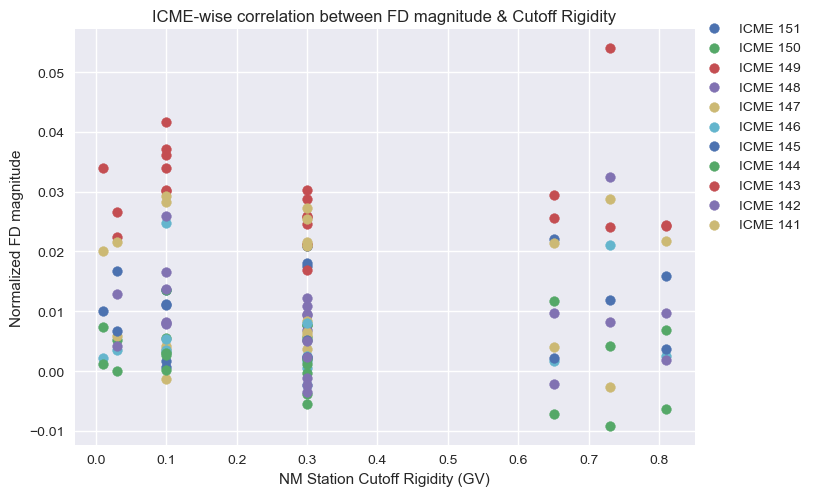

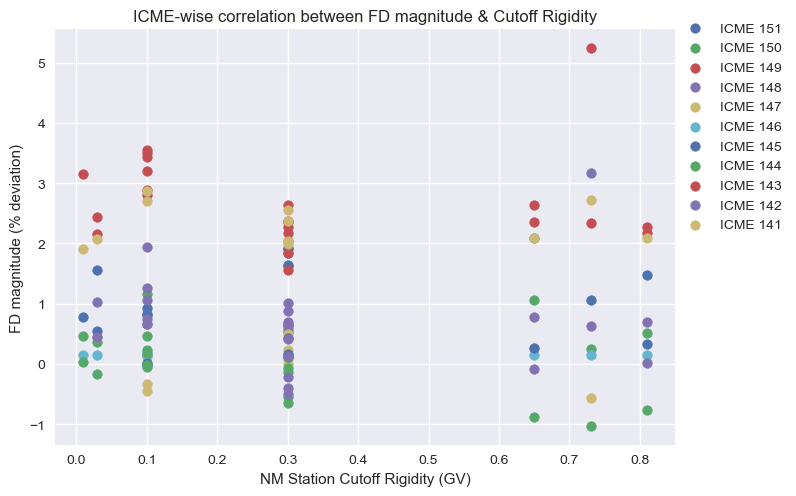

In [8]:

plt.style.use('seaborn')

cutoffrigs_151 = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03, 0.01])
plt.scatter(cutoffrigs_151, fdmags_count_151, label="ICME 151")

cutoffrigs_150 = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03, 0.01])
plt.scatter(cutoffrigs_150, fdmags_count_150, label="ICME 150")

cutoffrigs_149 = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03, 0.01])
plt.scatter(cutoffrigs_149, fdmags_count_149, label="ICME 149")

cutoffrigs_148 = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03])
plt.scatter(cutoffrigs_148, fdmags_count_148, label="ICME 148")

cutoffrigs_147 = np.array([0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03])
plt.scatter(cutoffrigs_147, fdmags_count_147, label="ICME 147")

cutoffrigs_146 = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03, 0.01])
plt.scatter(cutoffrigs_146, fdmags_count_146, label="ICME 146")

cutoffrigs_145 = np.array([0.81, 0.65, 0.30, 0.30, 0.30, 0.10, 0.10, 0.03])
plt.scatter(cutoffrigs_145, fdmags_count_145, label="ICME 145")

cutoffrigs_144 = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03, 0.01])
plt.scatter(cutoffrigs_144, fdmags_count_144, label="ICME 144")

cutoffrigs_143 = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03])
plt.scatter(cutoffrigs_143, fdmags_count_143, label="ICME 143")

cutoffrigs_142 = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03])
plt.scatter(cutoffrigs_142, fdmags_count_142, label="ICME 142")

cutoffrigs_141 = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.03, 0.01])
plt.scatter(cutoffrigs_141, fdmags_count_141, label="ICME 141")


plt.xlabel("NM Station Cutoff Rigidity (GV)")
plt.ylabel("Normalized FD magnitude")
plt.title("ICME-wise correlation between FD magnitude & Cutoff Rigidity")

plt.legend(loc=(1,0.5))
plt.show()

plt.scatter(cutoffrigs_151, fdmags_percentdev_151, label="ICME 151")
plt.scatter(cutoffrigs_150, fdmags_percentdev_150, label="ICME 150")
plt.scatter(cutoffrigs_149, fdmags_percentdev_149, label="ICME 149")
plt.scatter(cutoffrigs_148, fdmags_percentdev_148, label="ICME 148")
plt.scatter(cutoffrigs_147, fdmags_percentdev_147, label="ICME 147")
plt.scatter(cutoffrigs_146, fdmags_percentdev_146, label="ICME 146")
plt.scatter(cutoffrigs_145, fdmags_percentdev_145, label="ICME 145")
plt.scatter(cutoffrigs_144, fdmags_percentdev_144, label="ICME 144")
plt.scatter(cutoffrigs_143, fdmags_percentdev_143, label="ICME 143")
plt.scatter(cutoffrigs_142, fdmags_percentdev_142, label="ICME 142")
plt.scatter(cutoffrigs_141, fdmags_percentdev_141, label="ICME 141")

plt.xlabel("NM Station Cutoff Rigidity (GV)")
plt.ylabel("FD magnitude (% deviation)")
plt.title("ICME-wise correlation between FD magnitude & Cutoff Rigidity")

plt.legend(loc=(1,0.5))
plt.show()





Corresponding Pearson R values for 13 stations - 
[ 0.30514119  0.04938196 -0.55283204 -0.4851995  -0.31280563  0.07224492
 -0.06586219 -0.83227578  0.12107235  0.05562486 -0.01437765]
Average pearson r value =  -0.1508988652169179
Corresponding Spearman R values for 13 stations - 
[ 0.49460568  0.10186932 -0.46873932 -0.46760194 -0.10594569 -0.15918344
  0.06137858 -0.72769571 -0.18265701 -0.29955749  0.15982574]
Average spearman r value =  -0.14488193563970778
Corresponding Kendall Tau values for 13 stations - 
[ 0.40728088  0.09631427 -0.42768869 -0.32125042 -0.08322504 -0.07022084
  0.07715167 -0.57581089 -0.11835542 -0.21980292  0.11618357]
Average kendall tau value =  -0.1017658014330801
Corresponding linregress slope values for 13 stations - 
[ 0.00498079  0.00052494 -0.00852683 -0.00507449 -0.00460244  0.00218646
 -0.0004779  -0.01305881  0.00478134  0.00241943 -0.00019027]
Average linregress slope value =  -0.0015488890311300713
Average error in linregress slope =  0.005914008

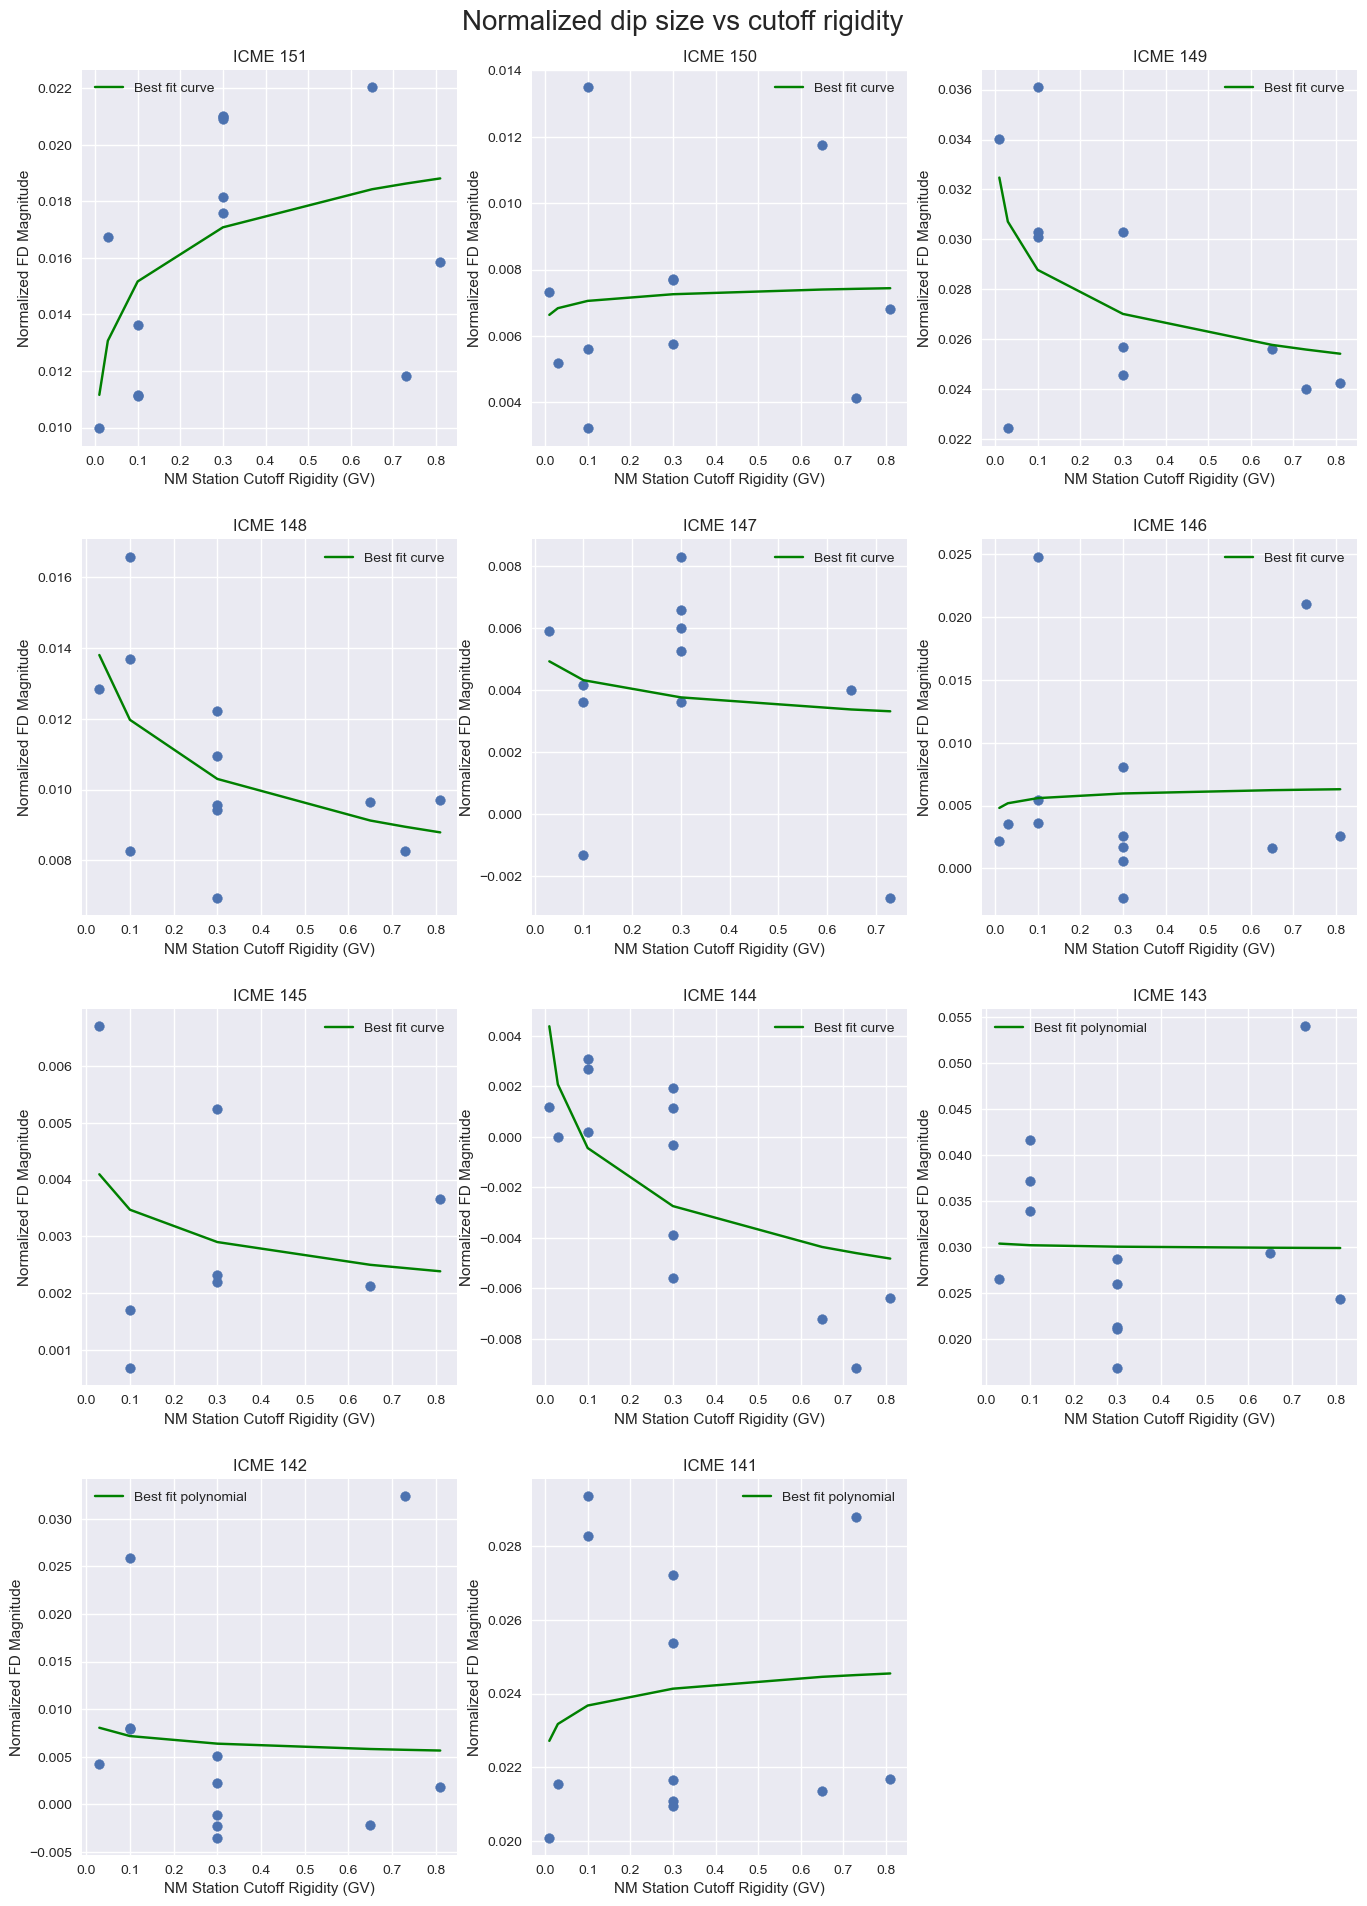

In [18]:
# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Adding subplots 

ax1 = fig.add_subplot(431, title="ICME 151", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )
ax2 = fig.add_subplot(432, title="ICME 150", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )
ax3 = fig.add_subplot(433, title="ICME 149", xlabel = "NM Station Cutoff Rigidity (GV)",
                   ylabel = "Normalized FD Magnitude" )
ax4 = fig.add_subplot(434, title="ICME 148", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )
ax5 = fig.add_subplot(435, title="ICME 147", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )
ax6 = fig.add_subplot(436, title="ICME 146", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )
ax7 = fig.add_subplot(437, title="ICME 145", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )
ax8 = fig.add_subplot(438, title="ICME 144", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )
ax9 = fig.add_subplot(439, title="ICME 143", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )
ax10 = fig.add_subplot(4,3,10, title="ICME 142", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )
ax11 = fig.add_subplot(4,3,11, title="ICME 141", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "Normalized FD Magnitude" )

# Defining 3rd degree polynomial function to best fit 
def f(x,a,b,c,d):
    return a + b*np.log(x) + c*np.log(x**2) + d*np.log(x**3)

    
ax1.scatter(cutoffrigs_151, fdmags_count_151)
popt, cov = curve_fit(f, cutoffrigs_151, fdmags_count_151) 
p,q,r,s = popt
ax1.plot(cutoffrigs_151, f(cutoffrigs_151,p,q,r,s), 'g', label="Best fit curve")
ax1.legend()

ax2.scatter(cutoffrigs_150, fdmags_count_150)
popt, cov = curve_fit(f, cutoffrigs_150, fdmags_count_150) 
p,q,r,s = popt
ax2.plot(cutoffrigs_150, f(cutoffrigs_150,p,q,r,s), 'g', label="Best fit curve")
ax2.legend()

ax3.scatter(cutoffrigs_149, fdmags_count_149)
popt, cov = curve_fit(f, cutoffrigs_149, fdmags_count_149) 
p,q,r,s  = popt
ax3.plot(cutoffrigs_149, f(cutoffrigs_149,p,q,r,s ), 'g', label="Best fit curve")
ax3.legend()

ax4.scatter(cutoffrigs_148, fdmags_count_148)
popt, cov = curve_fit(f, cutoffrigs_148, fdmags_count_148) 
p,q,r,s  = popt
ax4.plot(cutoffrigs_148, f(cutoffrigs_148,p,q,r,s ), 'g', label="Best fit curve")
ax4.legend()


ax5.scatter(cutoffrigs_147, fdmags_count_147)
popt, cov = curve_fit(f, cutoffrigs_147, fdmags_count_147) 
p,q,r,s  = popt
ax5.plot(cutoffrigs_147, f(cutoffrigs_147,p,q,r,s ), 'g', label="Best fit curve")
ax5.legend()

ax6.scatter(cutoffrigs_146, fdmags_count_146)
popt, cov = curve_fit(f, cutoffrigs_146, fdmags_count_146) 
p,q,r,s  = popt
ax6.plot(cutoffrigs_146, f(cutoffrigs_146,p,q,r,s ), 'g', label="Best fit curve")
ax6.legend()

ax7.scatter(cutoffrigs_145, fdmags_count_145)
popt, cov = curve_fit(f, cutoffrigs_145, fdmags_count_145) 
p,q,r,s  = popt
ax7.plot(cutoffrigs_145, f(cutoffrigs_145,p,q,r,s ), 'g', label="Best fit curve")
ax7.legend()

ax8.scatter(cutoffrigs_144, fdmags_count_144)
popt, cov = curve_fit(f, cutoffrigs_144, fdmags_count_144) 
p,q,r,s  = popt
ax8.plot(cutoffrigs_144, f(cutoffrigs_144,p,q,r,s ), 'g', label="Best fit curve")
ax8.legend()

ax9.scatter(cutoffrigs_143, fdmags_count_143)
popt, cov = curve_fit(f, cutoffrigs_143, fdmags_count_143) 
p,q,r,s  = popt
ax9.plot(cutoffrigs_143, f(cutoffrigs_143,p,q,r,s ), 'g', label="Best fit polynomial")
ax9.legend()

ax10.scatter(cutoffrigs_142, fdmags_count_142)
popt, cov = curve_fit(f, cutoffrigs_142, fdmags_count_142) 
p,q,r,s  = popt
ax10.plot(cutoffrigs_142, f(cutoffrigs_142,p,q,r,s ), 'g', label="Best fit polynomial")
ax10.legend()

ax11.scatter(cutoffrigs_141, fdmags_count_141)
popt, cov = curve_fit(f, cutoffrigs_141, fdmags_count_141) 
p,q,r,s  = popt
ax11.plot(cutoffrigs_141, f(cutoffrigs_141,p,q,r,s ), 'g', label="Best fit polynomial")
ax11.legend()

plt.suptitle("Normalized dip size vs cutoff rigidity", fontsize=20, y=1.24)



fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)

## Analyzing correlation coefficients - 

# NumPy np.corrcoef() gives same as scipy.stats.pearsonr()

# SciPy pearson R values = scpr  (linregress returns the same values)

scpr = np.array([ sct.pearsonr(cutoffrigs_151, fdmags_count_151)[0], sct.pearsonr(cutoffrigs_150, fdmags_count_150)[0], 
                  sct.pearsonr(cutoffrigs_149, fdmags_count_149)[0], sct.pearsonr(cutoffrigs_148, fdmags_count_148)[0], 
                  sct.pearsonr(cutoffrigs_147, fdmags_count_147)[0], sct.pearsonr(cutoffrigs_146, fdmags_count_146)[0], 
                  sct.pearsonr(cutoffrigs_145, fdmags_count_145)[0], sct.pearsonr(cutoffrigs_144, fdmags_count_144)[0], 
                  sct.pearsonr(cutoffrigs_143, fdmags_count_143)[0], sct.pearsonr(cutoffrigs_142, fdmags_count_142)[0], 
                  sct.pearsonr(cutoffrigs_141, fdmags_count_141)[0]])

# SciPy spearman r values = scsr

scsr = np.array([ sct.spearmanr(cutoffrigs_151, fdmags_count_151)[0], sct.spearmanr(cutoffrigs_150, fdmags_count_150)[0], 
                  sct.spearmanr(cutoffrigs_149, fdmags_count_149)[0], sct.spearmanr(cutoffrigs_148, fdmags_count_148)[0], 
                  sct.spearmanr(cutoffrigs_147, fdmags_count_147)[0], sct.spearmanr(cutoffrigs_146, fdmags_count_146)[0], 
                  sct.spearmanr(cutoffrigs_145, fdmags_count_145)[0], sct.spearmanr(cutoffrigs_144, fdmags_count_144)[0], 
                  sct.spearmanr(cutoffrigs_143, fdmags_count_143)[0], sct.spearmanr(cutoffrigs_142, fdmags_count_142)[0], 
                  sct.spearmanr(cutoffrigs_141, fdmags_count_141)[0]])

# SciPy kendall tau values = sckt

sckt = np.array([ sct.kendalltau(cutoffrigs_151, fdmags_count_151)[0], sct.kendalltau(cutoffrigs_150, fdmags_count_150)[0], 
                  sct.kendalltau(cutoffrigs_149, fdmags_count_149)[0], sct.kendalltau(cutoffrigs_148, fdmags_count_148)[0], 
                  sct.kendalltau(cutoffrigs_147, fdmags_count_147)[0], sct.kendalltau(cutoffrigs_146, fdmags_count_146)[0], 
                  sct.kendalltau(cutoffrigs_145, fdmags_count_145)[0], sct.kendalltau(cutoffrigs_144, fdmags_count_144)[0], 
                  sct.kendalltau(cutoffrigs_143, fdmags_count_143)[0], sct.kendalltau(cutoffrigs_142, fdmags_count_142)[0], 
                  sct.kendalltau(cutoffrigs_141, fdmags_count_141)[0]])


# SciPy linear regression slope values give strength of correlation - sclrm

sclrm = np.array([sct.linregress(cutoffrigs_151, fdmags_count_151)[0], sct.linregress(cutoffrigs_150, fdmags_count_150)[0], 
                  sct.linregress(cutoffrigs_149, fdmags_count_149)[0], sct.linregress(cutoffrigs_148, fdmags_count_148)[0], 
                  sct.linregress(cutoffrigs_147, fdmags_count_147)[0], sct.linregress(cutoffrigs_146, fdmags_count_146)[0], 
                  sct.linregress(cutoffrigs_145, fdmags_count_145)[0], sct.linregress(cutoffrigs_144, fdmags_count_144)[0], 
                  sct.linregress(cutoffrigs_143, fdmags_count_143)[0], sct.linregress(cutoffrigs_142, fdmags_count_142)[0], 
                  sct.linregress(cutoffrigs_141, fdmags_count_141)[0]])

## Estimating error in linregress slop - sclre

sclre = np.array([sct.linregress(cutoffrigs_151, fdmags_count_151)[4], sct.linregress(cutoffrigs_150, fdmags_count_150)[4], 
                  sct.linregress(cutoffrigs_149, fdmags_count_149)[4], sct.linregress(cutoffrigs_148, fdmags_count_148)[4], 
                  sct.linregress(cutoffrigs_147, fdmags_count_147)[4], sct.linregress(cutoffrigs_146, fdmags_count_146)[4], 
                  sct.linregress(cutoffrigs_145, fdmags_count_145)[4], sct.linregress(cutoffrigs_144, fdmags_count_144)[4], 
                  sct.linregress(cutoffrigs_143, fdmags_count_143)[4], sct.linregress(cutoffrigs_142, fdmags_count_142)[4], 
                  sct.linregress(cutoffrigs_141, fdmags_count_141)[4]])




print(f"Corresponding Pearson R values for 13 stations - ")
print(scpr)
print("Average pearson r value = ", np.mean(scpr)) 

print(f"Corresponding Spearman R values for 13 stations - ")
print(scsr)
print("Average spearman r value = ", np.mean(scsr))

print(f"Corresponding Kendall Tau values for 13 stations - ")
print(sckt)
print("Average kendall tau value = ", np.mean(sckt))

print(f"Corresponding linregress slope values for 13 stations - ")
print(sclrm)
print("Average linregress slope value = ", np.mean(sclrm))

print("Average error in linregress slope = ", np.mean(sclre))


In [9]:
## Analyzing correlation coefficients - 

# NumPy np.corrcoef() gives same as scipy.stats.pearsonr()

# SciPy pearson R values = scpr  (linregress returns the same values)

scpr = np.array([ sct.pearsonr(cutoffrigs_151, fdmags_count_151)[0], sct.pearsonr(cutoffrigs_150, fdmags_count_150)[0], 
                  sct.pearsonr(cutoffrigs_149, fdmags_count_149)[0], sct.pearsonr(cutoffrigs_148, fdmags_count_148)[0], 
                  sct.pearsonr(cutoffrigs_147, fdmags_count_147)[0], sct.pearsonr(cutoffrigs_146, fdmags_count_146)[0], 
                  sct.pearsonr(cutoffrigs_145, fdmags_count_145)[0], sct.pearsonr(cutoffrigs_144, fdmags_count_144)[0], 
                  sct.pearsonr(cutoffrigs_143, fdmags_count_143)[0], sct.pearsonr(cutoffrigs_142, fdmags_count_142)[0], 
                  sct.pearsonr(cutoffrigs_141, fdmags_count_141)[0]])

# SciPy spearman r values = scsr

scsr = np.array([ sct.spearmanr(cutoffrigs_151, fdmags_count_151)[0], sct.spearmanr(cutoffrigs_150, fdmags_count_150)[0], 
                  sct.spearmanr(cutoffrigs_149, fdmags_count_149)[0], sct.spearmanr(cutoffrigs_148, fdmags_count_148)[0], 
                  sct.spearmanr(cutoffrigs_147, fdmags_count_147)[0], sct.spearmanr(cutoffrigs_146, fdmags_count_146)[0], 
                  sct.spearmanr(cutoffrigs_145, fdmags_count_145)[0], sct.spearmanr(cutoffrigs_144, fdmags_count_144)[0], 
                  sct.spearmanr(cutoffrigs_143, fdmags_count_143)[0], sct.spearmanr(cutoffrigs_142, fdmags_count_142)[0], 
                  sct.spearmanr(cutoffrigs_141, fdmags_count_141)[0]])

# SciPy kendall tau values = sckt

sckt = np.array([ sct.kendalltau(cutoffrigs_151, fdmags_count_151)[0], sct.kendalltau(cutoffrigs_150, fdmags_count_150)[0], 
                  sct.kendalltau(cutoffrigs_149, fdmags_count_149)[0], sct.kendalltau(cutoffrigs_148, fdmags_count_148)[0], 
                  sct.kendalltau(cutoffrigs_147, fdmags_count_147)[0], sct.kendalltau(cutoffrigs_146, fdmags_count_146)[0], 
                  sct.kendalltau(cutoffrigs_145, fdmags_count_145)[0], sct.kendalltau(cutoffrigs_144, fdmags_count_144)[0], 
                  sct.kendalltau(cutoffrigs_143, fdmags_count_143)[0], sct.kendalltau(cutoffrigs_142, fdmags_count_142)[0], 
                  sct.kendalltau(cutoffrigs_141, fdmags_count_141)[0]])


# SciPy linear regression slope values give strength of correlation - sclrm

sclrm = np.array([sct.linregress(cutoffrigs_151, fdmags_count_151)[0], sct.linregress(cutoffrigs_150, fdmags_count_150)[0], 
                  sct.linregress(cutoffrigs_149, fdmags_count_149)[0], sct.linregress(cutoffrigs_148, fdmags_count_148)[0], 
                  sct.linregress(cutoffrigs_147, fdmags_count_147)[0], sct.linregress(cutoffrigs_146, fdmags_count_146)[0], 
                  sct.linregress(cutoffrigs_145, fdmags_count_145)[0], sct.linregress(cutoffrigs_144, fdmags_count_144)[0], 
                  sct.linregress(cutoffrigs_143, fdmags_count_143)[0], sct.linregress(cutoffrigs_142, fdmags_count_142)[0], 
                  sct.linregress(cutoffrigs_141, fdmags_count_141)[0]])

## Estimating error in linregress slop - sclre

sclre = np.array([sct.linregress(cutoffrigs_151, fdmags_count_151)[4], sct.linregress(cutoffrigs_150, fdmags_count_150)[4], 
                  sct.linregress(cutoffrigs_149, fdmags_count_149)[4], sct.linregress(cutoffrigs_148, fdmags_count_148)[4], 
                  sct.linregress(cutoffrigs_147, fdmags_count_147)[4], sct.linregress(cutoffrigs_146, fdmags_count_146)[4], 
                  sct.linregress(cutoffrigs_145, fdmags_count_145)[4], sct.linregress(cutoffrigs_144, fdmags_count_144)[4], 
                  sct.linregress(cutoffrigs_143, fdmags_count_143)[4], sct.linregress(cutoffrigs_142, fdmags_count_142)[4], 
                  sct.linregress(cutoffrigs_141, fdmags_count_141)[4]])



print("Average pearson r value = ", np.mean(scpr))
print("Average spearman r value = ", np.mean(scsr))
print("Average kendall tau value = ", np.mean(sckt))
print("Average linregress slope value = ", np.mean(sclrm))
print("Average error in linregress slope = ", np.mean(sclre))



Average pearson r value =  -0.1508988652169179
Average spearman r value =  -0.14488193563970778
Average kendall tau value =  -0.1017658014330801
Average linregress slope value =  -0.0015488890311300713
Average error in linregress slope =  0.005914008951476121


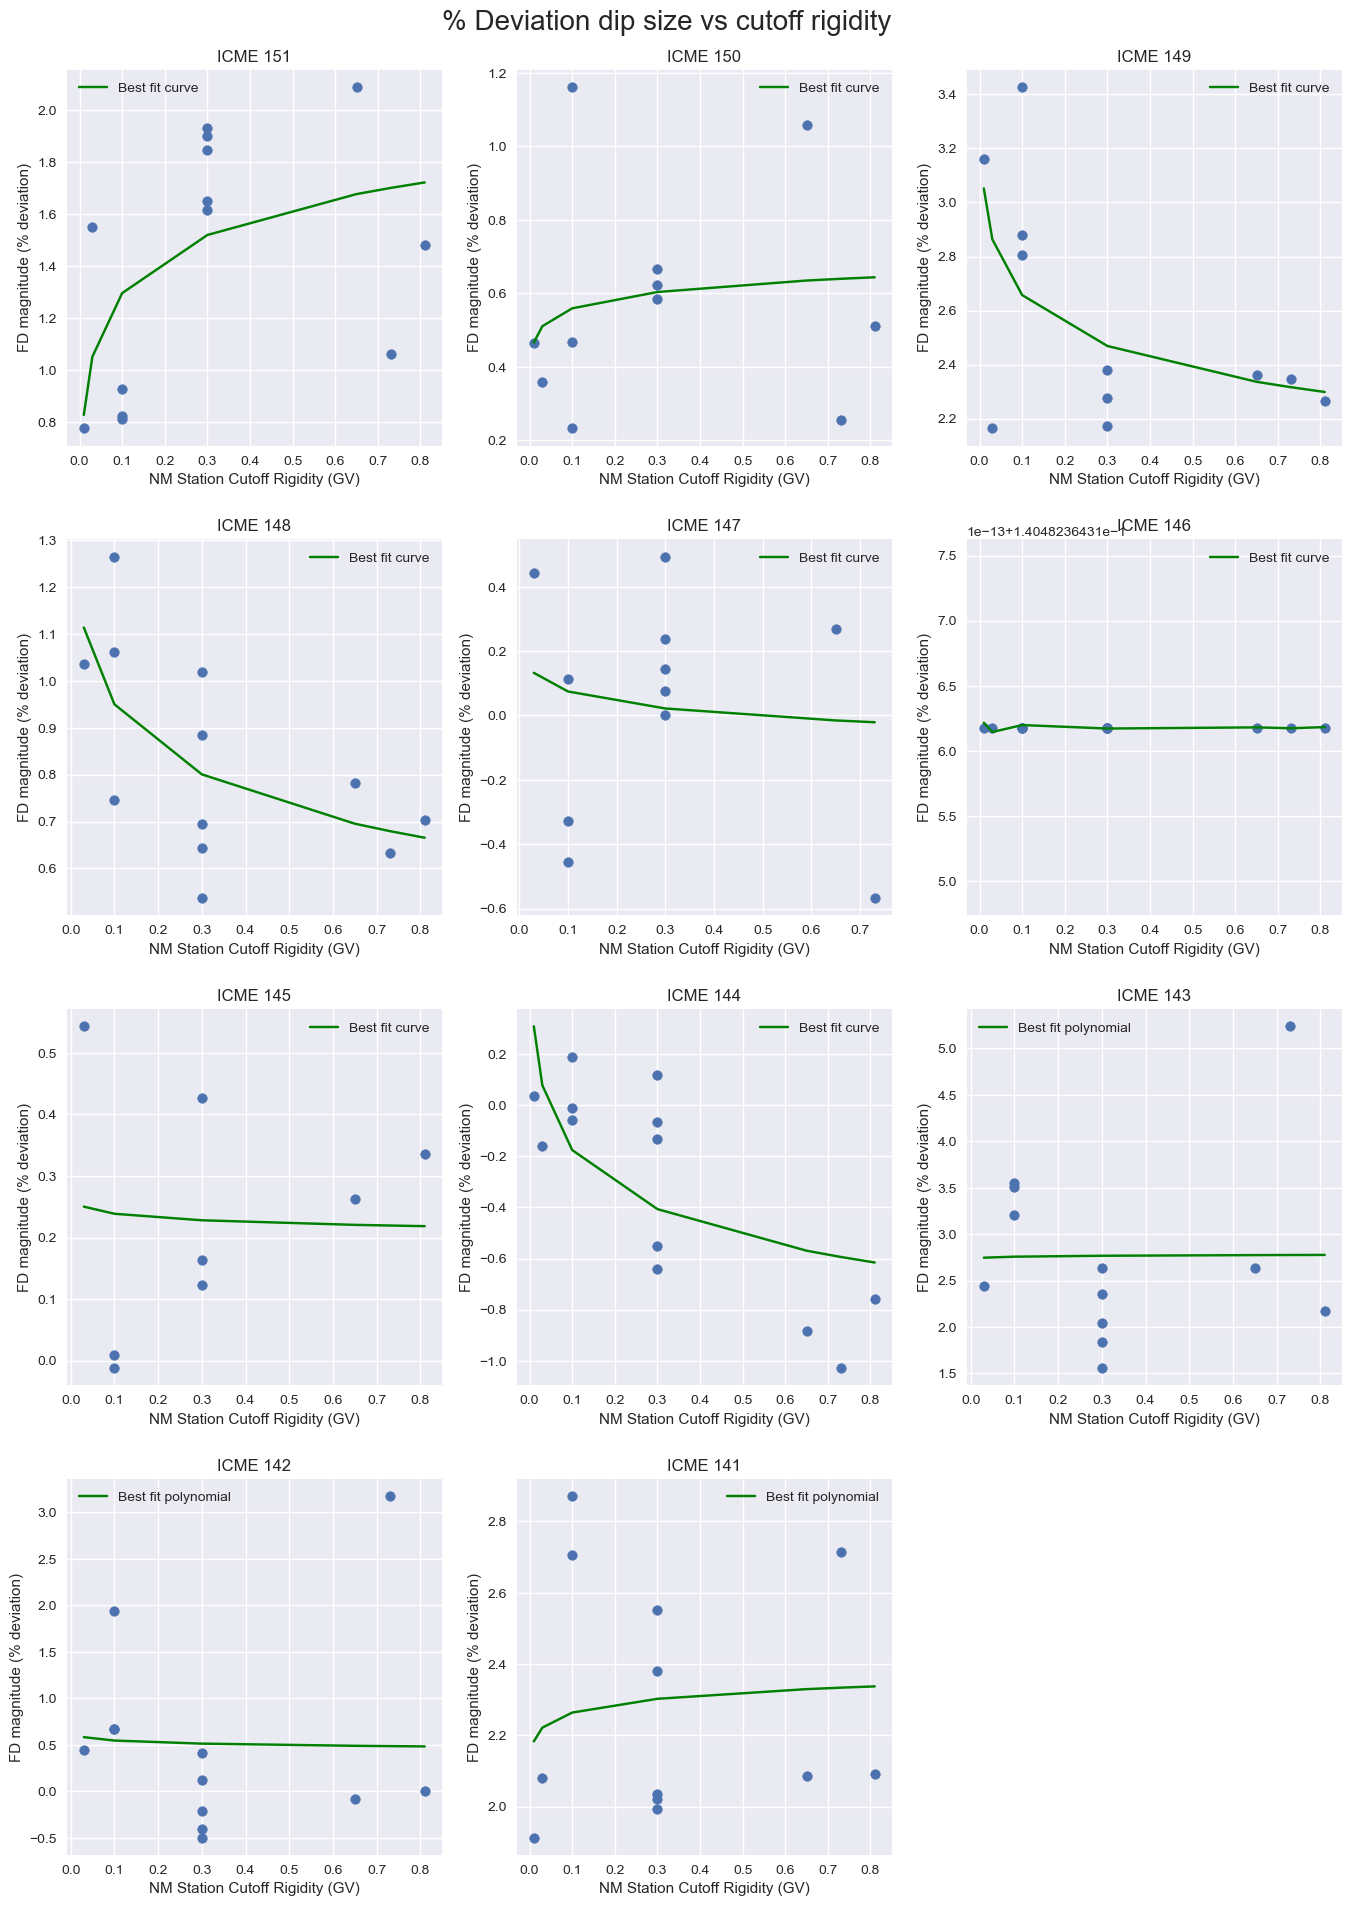

In [15]:
# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Adding subplots 

ax1 = fig.add_subplot(431, title="ICME 151", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax2 = fig.add_subplot(432, title="ICME 150", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax3 = fig.add_subplot(433, title="ICME 149", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax4 = fig.add_subplot(434, title="ICME 148", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax5 = fig.add_subplot(435, title="ICME 147", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax6 = fig.add_subplot(436, title="ICME 146", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax7 = fig.add_subplot(437, title="ICME 145", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax8 = fig.add_subplot(438, title="ICME 144", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax9 = fig.add_subplot(439, title="ICME 143", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax10 = fig.add_subplot(4,3,10, title="ICME 142", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )
ax11 = fig.add_subplot(4,3,11, title="ICME 141", xlabel = "NM Station Cutoff Rigidity (GV)",
                      ylabel = "FD magnitude (% deviation)" )

# Defining 3rd degree polynomial function to best fit 
def f(x,a,b,c,d):
    return a + b*np.log(x) + c*np.log(x**2) + d*np.log(x**3)
    
ax1.scatter(cutoffrigs_151, fdmags_percentdev_151)
popt, cov = curve_fit(f, cutoffrigs_151, fdmags_percentdev_151) 
p,q,r,s = popt
ax1.plot(cutoffrigs_151, f(cutoffrigs_151,p,q,r,s), 'g', label="Best fit curve")
ax1.legend()

ax2.scatter(cutoffrigs_150, fdmags_percentdev_150)
popt, cov = curve_fit(f, cutoffrigs_150, fdmags_percentdev_150) 
p,q,r,s = popt
ax2.plot(cutoffrigs_150, f(cutoffrigs_150,p,q,r,s), 'g', label="Best fit curve")
ax2.legend()

ax3.scatter(cutoffrigs_149, fdmags_percentdev_149)
popt, cov = curve_fit(f, cutoffrigs_149, fdmags_percentdev_149) 
p,q,r,s  = popt
ax3.plot(cutoffrigs_149, f(cutoffrigs_149,p,q,r,s ), 'g', label="Best fit curve")
ax3.legend()

ax4.scatter(cutoffrigs_148, fdmags_percentdev_148)
popt, cov = curve_fit(f, cutoffrigs_148, fdmags_percentdev_148) 
p,q,r,s  = popt
ax4.plot(cutoffrigs_148, f(cutoffrigs_148,p,q,r,s ), 'g', label="Best fit curve")
ax4.legend()


ax5.scatter(cutoffrigs_147, fdmags_percentdev_147)
popt, cov = curve_fit(f, cutoffrigs_147, fdmags_percentdev_147) 
p,q,r,s  = popt
ax5.plot(cutoffrigs_147, f(cutoffrigs_147,p,q,r,s ), 'g', label="Best fit curve")
ax5.legend()

ax6.scatter(cutoffrigs_146, fdmags_percentdev_146)
popt, cov = curve_fit(f, cutoffrigs_146, fdmags_percentdev_146) 
p,q,r,s  = popt
ax6.plot(cutoffrigs_146, f(cutoffrigs_146,p,q,r,s ), 'g', label="Best fit curve")
ax6.legend()

ax7.scatter(cutoffrigs_145, fdmags_percentdev_145)
popt, cov = curve_fit(f, cutoffrigs_145, fdmags_percentdev_145) 
p,q,r,s  = popt
ax7.plot(cutoffrigs_145, f(cutoffrigs_145,p,q,r,s ), 'g', label="Best fit curve")
ax7.legend()

ax8.scatter(cutoffrigs_144, fdmags_percentdev_144)
popt, cov = curve_fit(f, cutoffrigs_144, fdmags_percentdev_144) 
p,q,r,s  = popt
ax8.plot(cutoffrigs_144, f(cutoffrigs_144,p,q,r,s ), 'g', label="Best fit curve")
ax8.legend()

ax9.scatter(cutoffrigs_143, fdmags_percentdev_143)
popt, cov = curve_fit(f, cutoffrigs_143, fdmags_percentdev_143) 
p,q,r,s  = popt
ax9.plot(cutoffrigs_143, f(cutoffrigs_143,p,q,r,s ), 'g', label="Best fit polynomial")
ax9.legend()

ax10.scatter(cutoffrigs_142, fdmags_percentdev_142)
popt, cov = curve_fit(f, cutoffrigs_142, fdmags_percentdev_142) 
p,q,r,s  = popt
ax10.plot(cutoffrigs_142, f(cutoffrigs_142,p,q,r,s ), 'g', label="Best fit polynomial")
ax10.legend()

ax11.scatter(cutoffrigs_141, fdmags_percentdev_141)
popt, cov = curve_fit(f, cutoffrigs_141, fdmags_percentdev_141) 
p,q,r,s  = popt
ax11.plot(cutoffrigs_141, f(cutoffrigs_141,p,q,r,s ), 'g', label="Best fit polynomial")
ax11.legend()

plt.suptitle("% Deviation dip size vs cutoff rigidity", fontsize=20, y=1.24)



fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)


In [17]:
## Analyzing correlation coefficients - (giving error right now)

# NumPy np.corrcoef() gives same as scipy.stats.pearsonr()

# SciPy pearson R values = scpr  (linregress returns the same values)

scpr = np.array([sct.pearsonr(cutoffrigs_151, fdmags_percentdev_151)[0], sct.pearsonr(cutoffrigs_150, fdmags_percentdev_150)[0], 
                sct.pearsonr(cutoffrigs_149, fdmags_percentdev_149)[0], sct.pearsonr(cutoffrigs_148, fdmags_percentdev_148)[0], 
                sct.pearsonr(cutoffrigs_147, fdmags_percentdev_147)[0], sct.pearsonr(cutoffrigs_146, fdmags_percentdev_146)[0], 
                sct.pearsonr(cutoffrigs_145, fdmags_percentdev_145)[0], sct.pearsonr(cutoffrigs_144, fdmags_percentdev_144)[0], 
                sct.pearsonr(cutoffrigs_143, fdmags_percentdev_143)[0], sct.pearsonr(cutoffrigs_142, fdmags_percentdev_142)[0], 
                sct.pearsonr(cutoffrigs_141, fdmags_percentdev_141)[0]])

# SciPy spearman r values = scsr

scsr = np.array([sct.spearmanr(cutoffrigs_151, fdmags_percentdev_151)[0], sct.spearmanr(cutoffrigs_150, fdmags_percentdev_150)[0], 
                sct.spearmanr(cutoffrigs_149, fdmags_percentdev_149)[0], sct.spearmanr(cutoffrigs_148, fdmags_percentdev_148)[0], 
                sct.spearmanr(cutoffrigs_147, fdmags_percentdev_147)[0], sct.spearmanr(cutoffrigs_146, fdmags_percentdev_146)[0], 
                sct.spearmanr(cutoffrigs_145, fdmags_percentdev_145)[0], sct.spearmanr(cutoffrigs_144, fdmags_percentdev_144)[0], 
                sct.spearmanr(cutoffrigs_143, fdmags_percentdev_143)[0], sct.spearmanr(cutoffrigs_142, fdmags_percentdev_142)[0], 
                sct.spearmanr(cutoffrigs_141, fdmags_percentdev_141)[0]])

# SciPy kendall tau values = sckt

sckt = np.array([sct.kendalltau(cutoffrigs_151, fdmags_percentdev_151)[0], sct.kendalltau(cutoffrigs_150, fdmags_percentdev_150)[0], 
                sct.kendalltau(cutoffrigs_149, fdmags_percentdev_149)[0], sct.kendalltau(cutoffrigs_148, fdmags_percentdev_148)[0], 
                sct.kendalltau(cutoffrigs_147, fdmags_percentdev_147)[0], sct.kendalltau(cutoffrigs_146, fdmags_percentdev_146)[0], 
                sct.kendalltau(cutoffrigs_145, fdmags_percentdev_145)[0], sct.kendalltau(cutoffrigs_144, fdmags_percentdev_144)[0], 
                sct.kendalltau(cutoffrigs_143, fdmags_percentdev_143)[0], sct.kendalltau(cutoffrigs_142, fdmags_percentdev_142)[0], 
                sct.kendalltau(cutoffrigs_141, fdmags_percentdev_141)[0]])


# SciPy linear regression slope values give strength of correlation - sclrm

sclrm = np.array([sct.linregress(cutoffrigs_151, fdmags_percentdev_151)[0], sct.linregress(cutoffrigs_150, fdmags_percentdev_150)[0], 
                sct.linregress(cutoffrigs_149, fdmags_percentdev_149)[0], sct.linregress(cutoffrigs_148, fdmags_percentdev_148)[0], 
                sct.linregress(cutoffrigs_147, fdmags_percentdev_147)[0], sct.linregress(cutoffrigs_146, fdmags_percentdev_146)[0], 
                sct.linregress(cutoffrigs_145, fdmags_percentdev_145)[0], sct.linregress(cutoffrigs_144, fdmags_percentdev_144)[0], 
                sct.linregress(cutoffrigs_143, fdmags_percentdev_143)[0], sct.linregress(cutoffrigs_142, fdmags_percentdev_142)[0], 
                sct.linregress(cutoffrigs_141, fdmags_percentdev_141)[0]])

## Estimating error in linregress slop - sclre

sclre = np.array([sct.linregress(cutoffrigs_151, fdmags_percentdev_151)[4], sct.linregress(cutoffrigs_150, fdmags_percentdev_150)[4], 
                sct.linregress(cutoffrigs_149, fdmags_percentdev_149)[4], sct.linregress(cutoffrigs_148, fdmags_percentdev_148)[4], 
                sct.linregress(cutoffrigs_147, fdmags_percentdev_147)[4], sct.linregress(cutoffrigs_146, fdmags_percentdev_146)[4], 
                sct.linregress(cutoffrigs_145, fdmags_percentdev_145)[4], sct.linregress(cutoffrigs_144, fdmags_percentdev_144)[4], 
                sct.linregress(cutoffrigs_143, fdmags_percentdev_143)[4], sct.linregress(cutoffrigs_142, fdmags_percentdev_142)[4], 
                sct.linregress(cutoffrigs_141, fdmags_percentdev_141)[4]])


print("Average pearson r value = ", np.mean(scpr))
print("Average spearman r value = ", np.mean(scsr))
print("Average kendall tau value = ", np.mean(sckt))
print("Average linregress slope value = ", np.mean(sclrm))
print("Average error in linregress slope = ", np.mean(sclre))



Average pearson r value =  nan
Average spearman r value =  nan
Average kendall tau value =  nan
Average linregress slope value =  -0.08081156833283042
Average error in linregress slope =  0.4928008323579423


C:\Users\ADITYA\anaconda3\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
